In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import MAE
from sklearn.metrics import mean_squared_error
from utilsforecast.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import trend

# Establecer el estilo de las gráficas
plt.style.use('seaborn-v0_8')

In [44]:
# ---------------------------
# 1. CARGA Y PREPROCESAMIENTO DEL DATASET
# ---------------------------
tickets = ["AAPL", "AMZN", "TSLA", "GOOGL", "MSFT"]
dfs = []
i = 0
for ticket in tickets:
    df = pd.read_csv(f'../Data/Global_Data_{ticket}.csv', parse_dates=['Date'])
    df['unique_id'] = i  # Asigna un identificador numérico a cada ticket
    i += 1
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

# Definir las características (variables financieras y de sentimiento)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 
            'SMA_50', 'SMA_200', 'RSI', 'MACD', 'MACD_signal', 
            'avg_sentiment', 'weighted_sentiment', 'sentiment_sma_7', 
            'sentiment_sma_14', 'tweet_count']

# Filtrar el DataFrame y ordenarlo
df_filt = df[['Date', 'unique_id'] + features]
df_filt = df_filt.sort_values(by=['unique_id', 'Date'])

# Reindexar para que cada 'unique_id' tenga un índice diario completo
dfs_with_full_dates = []
for unique_id in df_filt['unique_id'].unique():
    df_ticker = df_filt[df_filt['unique_id'] == unique_id]
    full_idx_ticker = pd.date_range(start=df_ticker['Date'].min(), end=df_ticker['Date'].max(), freq='D')
    df_ticker_reindexed = df_ticker.set_index('Date').reindex(full_idx_ticker).reset_index()
    df_ticker_reindexed.rename(columns={'index': 'Date'}, inplace=True)
    df_ticker_reindexed['unique_id'] = unique_id
    dfs_with_full_dates.append(df_ticker_reindexed)
df_filt_full = pd.concat(dfs_with_full_dates, ignore_index=True)

# Imputar valores faltantes por interpolación lineal
df_filt_full[features] = df_filt_full[features].interpolate(method='linear')

# (Opcional) Se puede aplicar escalado; en este ejemplo se conserva la estructura original
df_scaled = pd.DataFrame(df_filt_full[features], columns=features, index=df_filt_full.index)
df_filt_full[features] = df_scaled

# ---------------------------
# 2. CREACIÓN DE VARIABLES NUEVAS (LAGS Y DIFERENCIAS)
# ---------------------------
# Variables FUTURAS exógenas: aquellas que se conocen para el pronóstico
# Por ejemplo, el cierre de hace 7 días (para predecir mañana o en el horizonte)
df_filt_full['y_lag7'] = df_filt_full.groupby('unique_id')['Close'].shift(7)
# Los indicadores técnicos (SMA_50, SMA_200, RSI, MACD y MACD_signal) ya se calculan con datos históricos y estarán disponibles

# Variables HISTÓRICAS exógenas: lags de variables cuyos valores futuros no se pueden "predecir"
# Lags de variables de precios:
for feat in ['Open', 'High', 'Low', 'Volume', 'Close', 'SMA_50', 'SMA_200', 'RSI', 'MACD']:
    df_filt_full[f"{feat}_lag7"] = df_filt_full.groupby('unique_id')[feat].shift(7)

# Lags de variables de sentimiento (ya que el análisis de sentimiento se hace en función de datos pasados)
for feat in ['weighted_sentiment', 'tweet_count', 'sentiment_sma_7']:
    df_filt_full[f"{feat}_lag7"] = df_filt_full.groupby('unique_id')[feat].shift(7)

# Opcional: calcular diferencias en el cierre para captar cambios recientes
df_filt_full['y_diff14'] = df_filt_full['Close'] - df_filt_full.groupby('unique_id')['Close'].shift(7)

# ---------------------------
# 3. PREPARAR EL DATASET FINAL PARA EL MODELO
# ---------------------------
# Renombrar 'Date' a 'ds' y 'Close' a 'y' (requerido por NeuralForecast)
df_filt_full = df_filt_full.fillna(0)
df_final = df_filt_full.rename(columns={'Date': 'ds', 'Close': 'y'})

# ---------------------------
# 4. DEFINICIÓN DE LISTAS DE VARIABLES EXÓGENAS
# Variables FUTURAS exógenas (futr_exog_list):
# Estas se conocen para la predicción (ejemplo: y_lag7 y los indicadores técnicos calculados con datos históricos).
futr_exog_list = [
    'Open_lag7', 'High_lag7', 'Low_lag7', 'Volume_lag7', 'Close_lag7',
    'SMA_50_lag7', 'SMA_200_lag7', 'RSI_lag7', 'MACD_lag7',
    'weighted_sentiment_lag7', 'sentiment_sma_7_lag7','tweet_count_lag7',
]

df_final

,ds,unique_id,Open,High,Low,y,Volume,SMA_50,SMA_200,RSI,...,Volume_lag7,Close_lag7,SMA_50_lag7,SMA_200_lag7,RSI_lag7,MACD_lag7,weighted_sentiment_lag7,tweet_count_lag7,sentiment_sma_7_lag7,y_diff14
0,2016-10-19,0,-1.923882,-1.940571,-1.987976,-1.923895,-0.843739,-2.227854,-2.383641,0.439562,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2016-10-20,0,-1.925562,-1.951164,-1.916395,-1.934864,-0.541287,-2.222643,-2.380764,0.292853,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2016-10-21,0,-1.921433,-1.948655,-1.911656,-1.933176,-0.552137,-2.219828,-2.379146,0.306937,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2016-10-22,0,-1.917303,-1.946146,-1.906917,-1.931489,-0.562988,-2.217013,-2.377527,0.321021,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2016-10-23,0,-1.913173,-1.943637,-1.902178,-1.929801,-0.573839,-2.214198,-2.375909,0.335104,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5840,2019-12-27,4,2.078001,2.059150,2.101008,2.097364,-0.755330,1.872373,1.860070,1.736185,...,2.265131,2.016819,1.814937,1.820661,1.508624,1.439904,-1.640247,-0.570840,0.046008,0.080545
5841,2019-12-28,4,2.060497,2.052411,2.081831,2.091483,-0.814606,1.877174,1.863253,1.648411,...,1.238366,2.026664,1.819727,1.824098,1.559047,1.506800,-1.143412,-0.426814,0.047830,0.064819
5842,2019-12-29,4,2.042992,2.045672,2.062653,2.085602,-0.873882,1.881974,1.866436,1.560638,...,0.211602,2.036508,1.824516,1.827535,1.609470,1.573696,-0.646576,-0.282788,0.049651,0.049094
5843,2019-12-30,4,2.025487,2.038933,2.043476,2.079721,-0.933157,1.886774,1.869620,1.472865,...,-0.815163,2.046352,1.829306,1.830972,1.659893,1.640592,-0.149741,-0.138762,0.051473,0.033369


In [45]:
transformed_df, future_df = trend(df_final, freq='D', h=14)
transformed_df

,ds,unique_id,Open,High,Low,y,Volume,SMA_50,SMA_200,RSI,...,Close_lag7,SMA_50_lag7,SMA_200_lag7,RSI_lag7,MACD_lag7,weighted_sentiment_lag7,tweet_count_lag7,sentiment_sma_7_lag7,y_diff14,trend
0,2016-10-19,0,-1.923882,-1.940571,-1.987976,-1.923895,-0.843739,-2.227854,-2.383641,0.439562,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
1,2016-10-20,0,-1.925562,-1.951164,-1.916395,-1.934864,-0.541287,-2.222643,-2.380764,0.292853,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0
2,2016-10-21,0,-1.921433,-1.948655,-1.911656,-1.933176,-0.552137,-2.219828,-2.379146,0.306937,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.0
3,2016-10-22,0,-1.917303,-1.946146,-1.906917,-1.931489,-0.562988,-2.217013,-2.377527,0.321021,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.0
4,2016-10-23,0,-1.913173,-1.943637,-1.902178,-1.929801,-0.573839,-2.214198,-2.375909,0.335104,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5840,2019-12-27,4,2.078001,2.059150,2.101008,2.097364,-0.755330,1.872373,1.860070,1.736185,...,2.016819,1.814937,1.820661,1.508624,1.439904,-1.640247,-0.570840,0.046008,0.080545,1167.0
5841,2019-12-28,4,2.060497,2.052411,2.081831,2.091483,-0.814606,1.877174,1.863253,1.648411,...,2.026664,1.819727,1.824098,1.559047,1.506800,-1.143412,-0.426814,0.047830,0.064819,1168.0
5842,2019-12-29,4,2.042992,2.045672,2.062653,2.085602,-0.873882,1.881974,1.866436,1.560638,...,2.036508,1.824516,1.827535,1.609470,1.573696,-0.646576,-0.282788,0.049651,0.049094,1169.0
5843,2019-12-30,4,2.025487,2.038933,2.043476,2.079721,-0.933157,1.886774,1.869620,1.472865,...,2.046352,1.829306,1.830972,1.659893,1.640592,-0.149741,-0.138762,0.051473,0.033369,1170.0


In [46]:
# Dividir en conjunto de entrenamiento y prueba
train = transformed_df[transformed_df['ds'] <= '2019-09-30']
test = transformed_df[(transformed_df['ds'] > '2019-09-30')].reset_index(drop=True)

print(train.shape[0])
print(test.shape[0])

5385
460


In [ ]:
# Inicializar los modelos a evaluar
models = [
    # Modelo LSTM
    LSTM(
        h=7,
        input_size=14,
        encoder_n_layers=4,
        encoder_hidden_size=128,
        encoder_bias=True,
        encoder_dropout=0.2,
        decoder_hidden_size=128,
        decoder_layers=4,
        futr_exog_list=futr_exog_list,
        hist_exog_list=['trend'],
        loss=MAE(),
        scaler_type='robust',
        learning_rate=1e-4,
        max_steps=400,
        batch_size=128,
    )
]

# Crear el objeto NeuralForecast y ajustar el modelo
nf = NeuralForecast(
    models=models,
    freq='D'  # Frecuencia diaria
)

Seed set to 1


In [48]:
nf.fit(df=train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 463 K  | train
4 | context_adapter | Linear        | 14.9 K | train
5 | mlp_decoder     | MLP           | 36.1 K | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.060     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=600` reached.


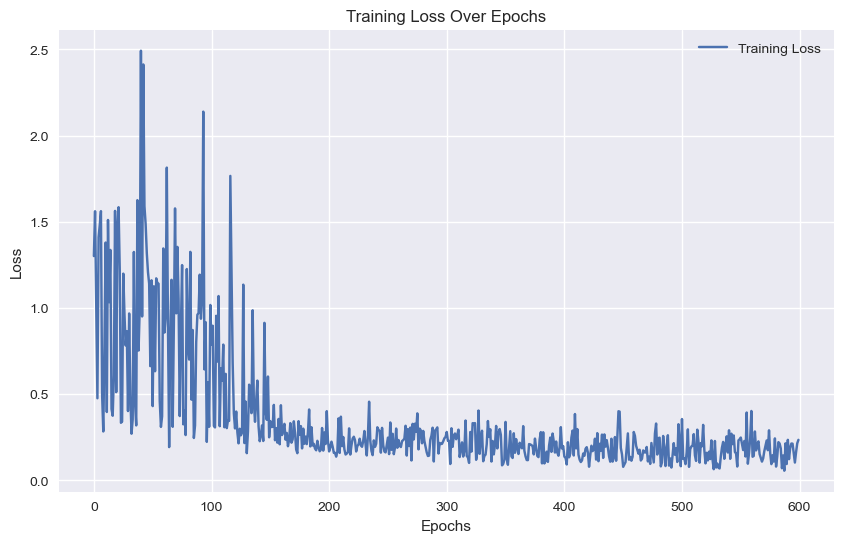

In [49]:
# Obtener el historial de pérdidas del modelo desde los resultados de entrenamiento
losses = nf.models[0].train_trajectories

# Extraer los valores de la pérdida y las épocas
epochs = [x[0] for x in losses]  # Épocas
train_loss = [x[1] for x in losses]  # Pérdidas

# Graficar las pérdidas de entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss")

# Añadir etiquetas y título
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Mostrar la gráfica
plt.show()

## Validación del Modelo

In [50]:
cv_result = nf.cross_validation(df=train, n_windows=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 463 K  | train
4 | context_adapter | Linear        | 14.9 K | train
5 | mlp_decoder     | MLP           | 36.1 K | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.060     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=600` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [51]:
Y_aapl = train[train['unique_id'] == 0][1100:]

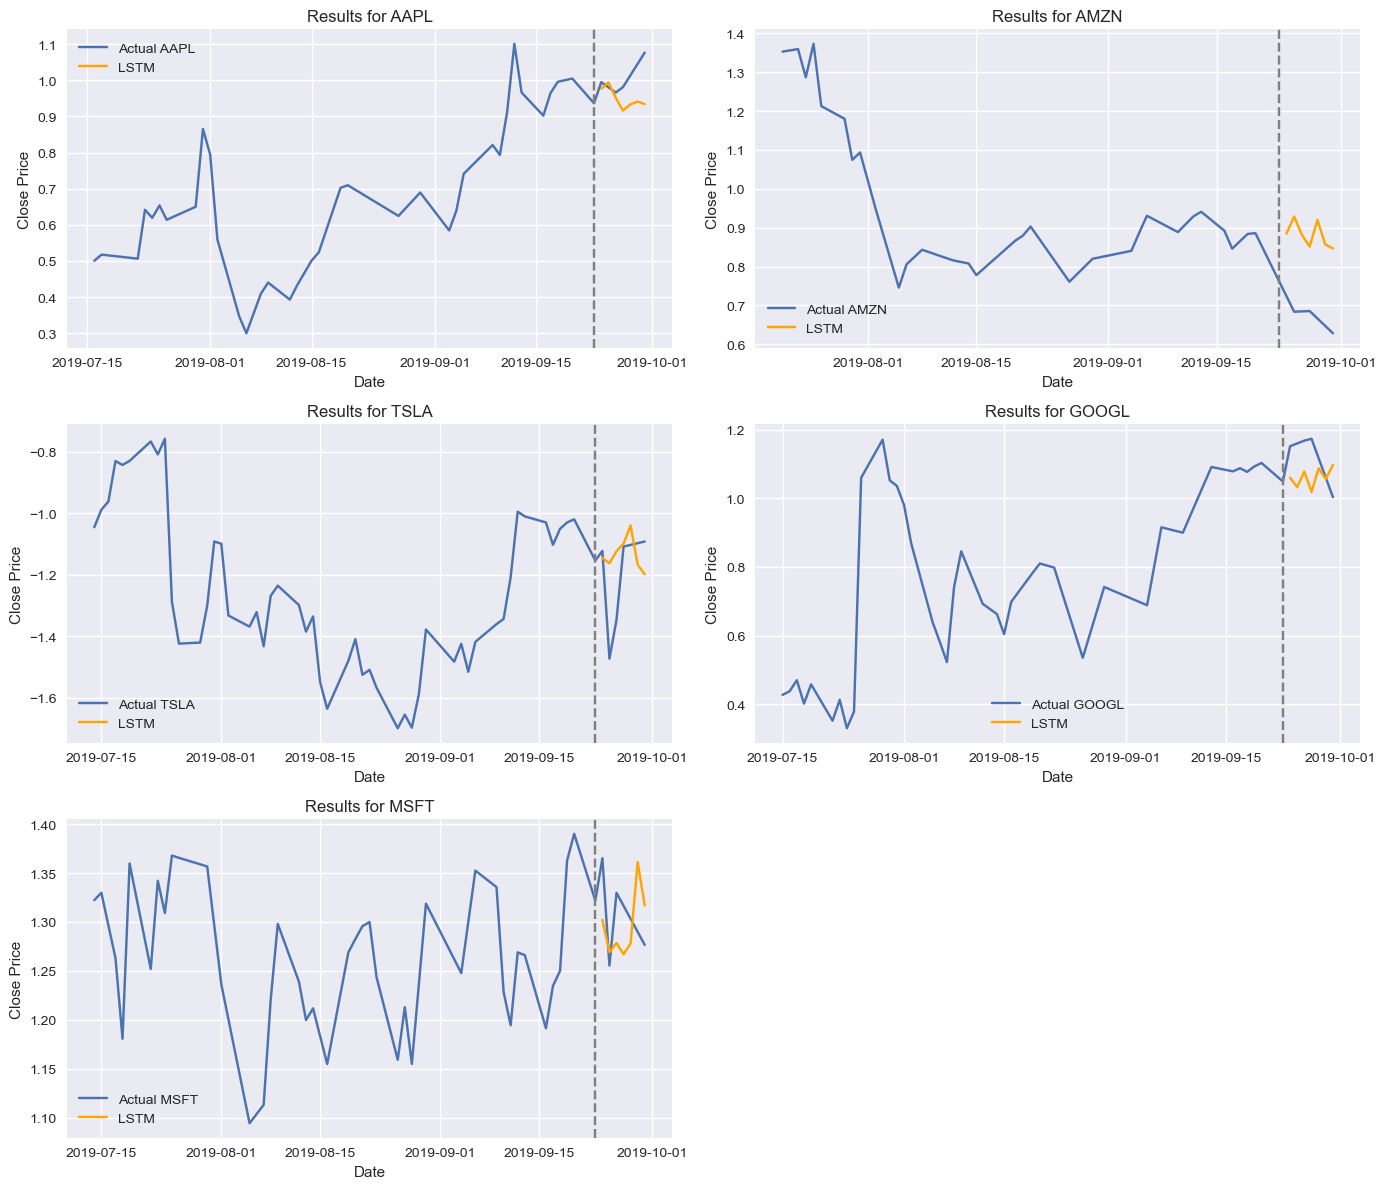

In [52]:
import matplotlib.pyplot as plt

# Definir la figura con 3 filas y 2 columnas
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar la iteración

# Iterar sobre las empresas y graficarlas en sus respectivos subgráficos
for i, company in enumerate(tickets):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Filtrar los datos de entrenamiento y los resultados de la validación cruzada para cada empresa
    Y_company = train[train['unique_id'] == range(0, 5)[i]][1000:]
    cv_res_company = cv_result[cv_result['unique_id'] == range(0, 5)[i]]

    # Obtener los puntos de corte únicos
    cutoffs = cv_res_company['cutoff'].unique()

    # Graficar los datos reales y predicciones
    ax.plot(Y_company['ds'], Y_company['y'], label=f"Actual {company}")
    ax.plot(cv_res_company['ds'], cv_res_company['LSTM'], label='LSTM', color='orange')

    # Añadir las líneas de corte
    for cutoff in cutoffs:
        ax.axvline(x=cutoff, color='grey', ls='--')

    # Configurar el gráfico
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.set_title(f'Results for {company}')
    ax.legend()

# Dejar el último cuadro vacío
axes[-1].axis('off')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar la figura con todas las subgráficas
plt.show()


In [53]:
# Calcular las métricas de cada empresa
metrics = []

empresa_dict = {0: 'AAPL', 1: 'AMZN', 2: 'TSLA', 3: 'GOOGL', 4: 'MSFT'}

# Agrupar por empresa (unique_id)
for empresa_id, group in cv_result.groupby('unique_id'):
    y_true = group['y']
    y_pred = group['LSTM']
    
    # Calcular MAE, RMSE, MAPE para cada empresa
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.sqrt(mape)
    r2 = r2_score(y_true,y_pred)
    
    # Guardar los resultados
    metrics.append({
        'Empresa': empresa_dict[empresa_id],
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape,
        'R2': r2
    })

# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame(metrics)

# Mostrar las métricas
metrics_df

,Empresa,MAE,MSE,RMSE,MAPE,SMAPE,R2
0,AAPL,0.062588,0.006069,0.077901,6.065354,2.462794,-3.461120
1,AMZN,0.207076,0.043980,0.209713,30.867604,5.555862,-53.167981
2,TSLA,0.115056,0.023819,0.154336,8.912595,2.985397,-0.178346
3,GOOGL,0.084308,0.009465,0.097286,7.447303,2.728975,-1.652023
4,MSFT,0.044903,0.002369,0.048677,3.420457,1.849448,-1.108911


## Evaluación del Modelo

In [54]:
# Realizar predicciones utilizando el conjunto de prueba y las variables exógenas futuras
forecasts = nf.predict(futr_df=test)
forecasts

c:\Users\pmyoe\anaconda3\Lib\site-packages\neuralforecast\core.py:904: UserWarning: Dropped 425 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,LSTM
0,0,2019-10-01,0.947428
1,0,2019-10-02,0.993003
2,0,2019-10-03,0.995042
3,0,2019-10-04,0.945879
4,0,2019-10-05,0.991929
5,0,2019-10-06,0.986871
6,0,2019-10-07,1.009787
7,1,2019-10-01,0.611885
8,1,2019-10-02,0.619056
9,1,2019-10-03,0.651831


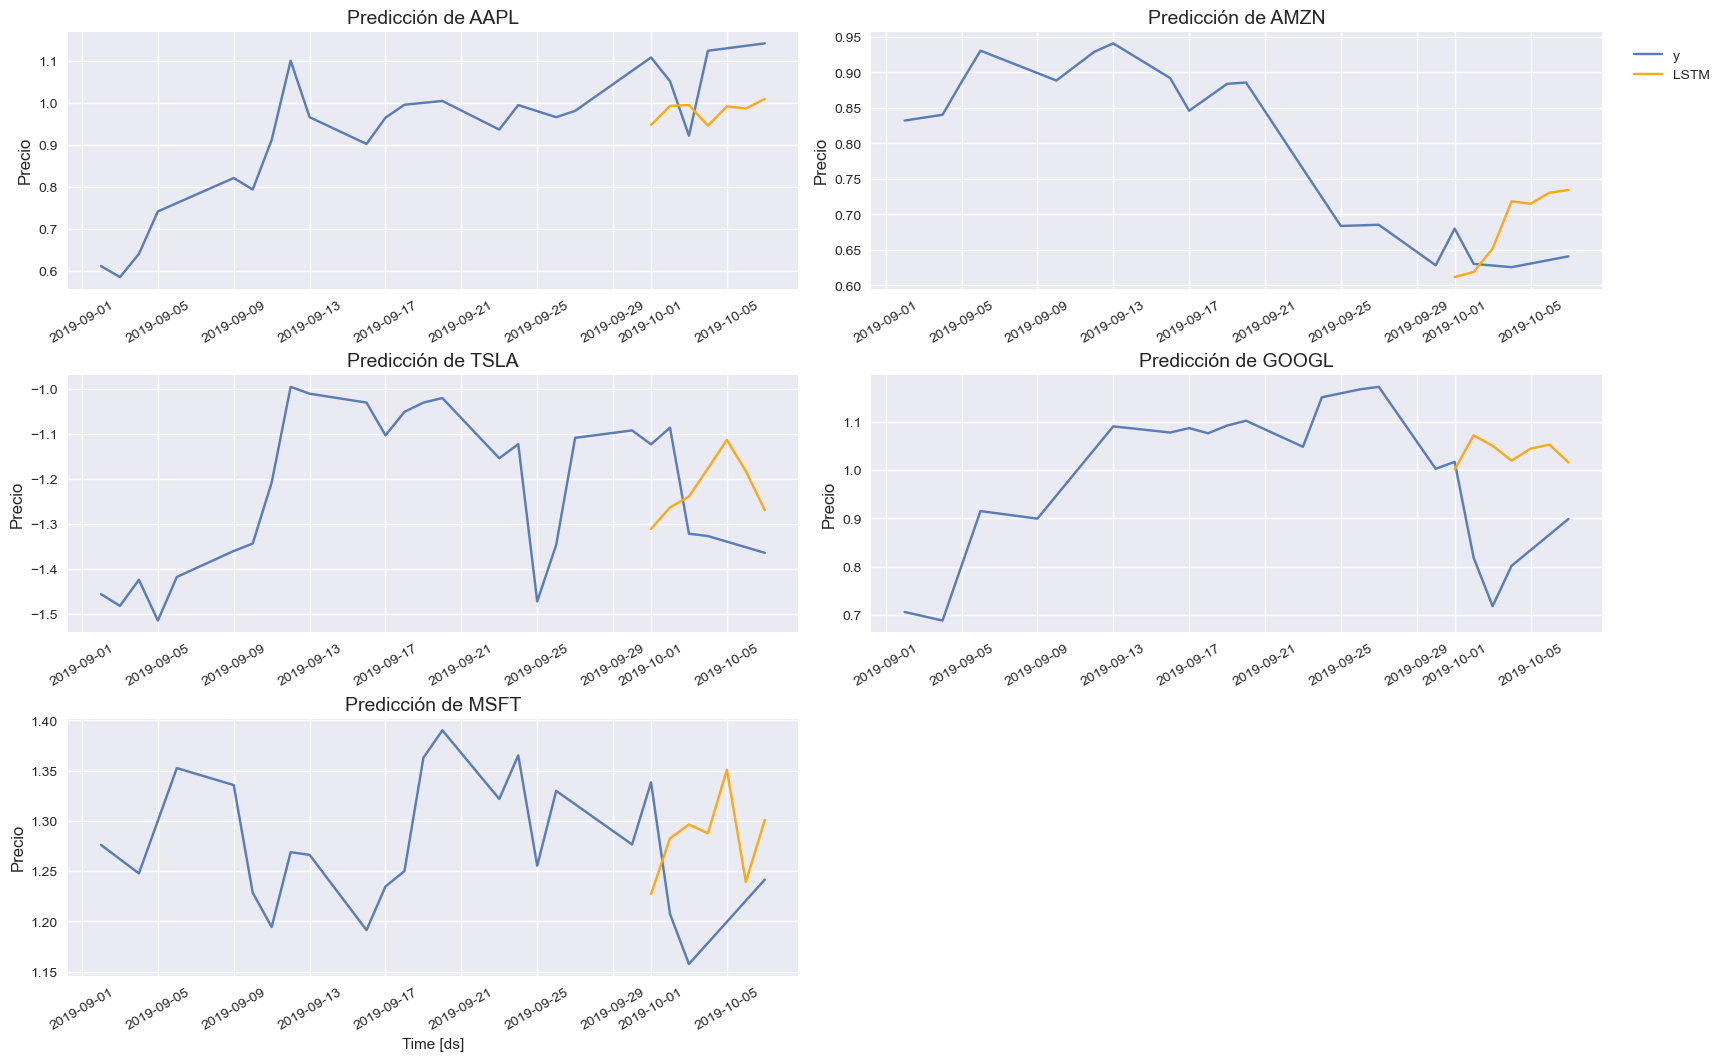

In [57]:
# Filtrar los datos para el rango de fechas especificado
df_filtered = df_final[(df_final['ds'] > '2019-09-01') & (df_final['ds'] <= '2019-10-07')]


# Graficar con plot_series (la función retorna una figura, no un par de valores)
fig = plot_series(
    df_filtered,         # Datos reales
    forecasts_df=forecasts,  # Predicciones
    engine='matplotlib',     # Usar matplotlib como motor de gráficos
    id_col='unique_id',      # Columna que identifica las series (empresas)
    time_col='ds',           # Columna de fechas
    target_col='y',          # Columna de la variable objetivo
    plot_random=False,       # No graficar aleatoriamente
    real_color = '#597db8',
    forecast_color = '#fbaa18'
)

# Diccionario que mapea unique_id con nombres de empresas
empresa_dict = {0: 'AAPL', 1: 'AMZN', 2: 'TSLA', 3: 'GOOGL', 4: 'MSFT'}  # Ejemplo

# Acceder a los ejes y añadir títulos
# Acceder a los ejes y añadir títulos
for ax, unique_id in zip(fig.axes, forecasts['unique_id'].unique()):
    # Obtener el nombre de la empresa desde el diccionario
    nombre_empresa = empresa_dict.get(unique_id, "Empresa Desconocida")  # Mapeo al nombre de la empresa
    
    # Establecer título con el nombre de la empresa
    ax.set_title(f"Predicción de {nombre_empresa}", fontsize=14)
    
    # Cambiar el título del eje y
    ax.set_ylabel('Precio', fontsize=12)


fig



In [58]:
from utilsforecast.losses import *

# Renombrar la predicción del modelo TFT
forecasts = forecasts.rename(columns={'LSTM_pred': 'LSTM'})  

# Fusionar predicciones con el conjunto de prueba usando sufijos para evitar columnas duplicadas
test = test.merge(forecasts, on=['ds', 'unique_id'], how='left', suffixes=('', '_forecast'))

# Evaluar el modelo TFT
evaluation = evaluate(
    df=test,  # Conjunto de prueba con predicciones
    metrics=[mae, mse, rmse, mape, smape],  # Métricas de error
    models=['LSTM']  # Modelo a evaluar
)

# Agrupar por empresa y métrica
summary_by_company = evaluation.groupby(['unique_id', 'metric']).mean().reset_index()

# Pivotar el DataFrame para que cada métrica sea una columna
summary_pivot = summary_by_company.pivot(index='unique_id', columns='metric', values='LSTM').reset_index()

# Renombrar las compañías en la columna 'unique_id'
companies = ["AAPL", "AMZN", "TSLA", "GOOGL", "MSFT"]
summary_pivot['unique_id'] = companies

# Eliminar el índice 'metric' si está presente
summary_pivot = summary_pivot.reset_index(drop=True)

# Renombrar la columna 'unique_id' a 'Empresa'
summary_pivot = summary_pivot.rename(columns={'unique_id': 'Empresa'})

# Convertir las métricas a mayúsculas
summary_pivot.columns = [col.upper() if col not in ['Empresa'] else col for col in summary_pivot.columns]

# Eliminar cualquier columna que sea un índice residual
summary_pivot.columns.name = None  # Esto elimina el nombre del índice

# Reordenar las columnas en el orden deseado
summary_pivot = summary_pivot[['Empresa', 'MAE', 'MSE', 'RMSE', 'MAPE', 'SMAPE']]

# Mostrar el resultado final
summary_pivot



,Empresa,MAE,MSE,RMSE,MAPE,SMAPE
0,AAPL,0.127608,0.018004,0.134180,0.115767,0.004666
1,AMZN,0.066919,0.005534,0.074394,0.104644,0.003796
2,TSLA,0.155806,0.026528,0.162873,0.124523,0.004792
3,GOOGL,0.190754,0.045138,0.212457,0.237116,0.007833
4,MSFT,0.094714,0.010831,0.104072,0.078074,0.002873
